<a href="https://colab.research.google.com/github/redpony/seaml_intro_nns/blob/master/MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
tf.compat.v2.enable_v2_behavior()

# Point of this notebook

 * Demonstrate the simplicity of working with an autodiff framework
 * Improve performance on MNIST digit classification task
   * Better optimizer
   * Add dropout

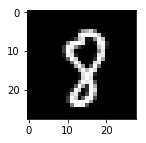

In [3]:
# Construct a tf.data.Dataset
dataset = tfds.load(name="mnist", split=tfds.Split.TRAIN)
test_dataset = tfds.load(name="mnist", split=tfds.Split.TEST)
example_image = next(iter(dataset))['image']

plt.figure(figsize=(2,2))
plt.imshow(tf.reshape(example_image, [28, 28]), cmap='gray')

In [0]:
class MLPModel(layers.Layer):
    def __init__(self, outputs=10, hiddens=1024, activation=tf.nn.relu):
        super(MLPModel, self).__init__()

        self.fc1 = layers.Dense(hiddens, activation=activation)
        self.fc2 = layers.Dense(outputs, activation=None)

    def __call__(self, x):
        x = tf.reshape(x, [-1, 28 * 28])
        h = self.fc1(x)
        logits = self.fc2(h)
        return logits

In [0]:
batched_dataset = dataset.repeat(-1).shuffle(4096).batch(32)  # -1 = repeat forever
batched_test_dataset = test_dataset.batch(32, drop_remainder=False)

In [7]:
# Create model
m = MLPModel()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

# Training loop

NUM_BATCHES = 5000
REPORT_EVERY_I = 250
TEST_EVERY_I = 500
updates = 0
eloss = None
EMA_ALPHA = 0.1
losses = []

for features in batched_dataset.take(NUM_BATCHES):
    image, label = features["image"], features["label"]
    image = tf.cast(image, dtype=tf.float32) / 255.0
    with tf.GradientTape() as tape:
        logits = m(image)
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label,
                                                           logits=logits))
        
    # track exponential moving average of 
    if eloss is None:
        eloss = loss.numpy()
    else:
        eloss = eloss * (1 - EMA_ALPHA) + loss.numpy() * EMA_ALPHA
    losses.append(eloss)
    if updates % REPORT_EVERY_I == 0:
        correct = 0.0
        total = 0.0
        if updates % TEST_EVERY_I == 0:
            for features in batched_test_dataset:
                image, label = features["image"], features["label"]
                image = tf.cast(image, dtype=tf.float32) / 255.0
                logits = m(image)
                preds = tf.argmax(logits, axis=-1)
                total += image.shape[0]
                z = tf.equal(preds - label, 0)
                correct += tf.reduce_sum(tf.cast(z, tf.float32))
            print("[{}] Test accuracy: {} ({} of {})".format(updates, correct / total, correct, total))
    updates += 1
    grads = tape.gradient(loss, m.trainable_weights)
    optimizer.apply_gradients(grads_and_vars=zip(grads, m.trainable_weights))

[0] Test accuracy: 0.12770000100135803 (1277.0 of 10000.0)
[500] Test accuracy: 0.6643000245094299 (6643.0 of 10000.0)
[1000] Test accuracy: 0.7674000263214111 (7674.0 of 10000.0)
[1500] Test accuracy: 0.8184000253677368 (8184.0 of 10000.0)
[2000] Test accuracy: 0.8345999717712402 (8346.0 of 10000.0)
[2500] Test accuracy: 0.8500999808311462 (8501.0 of 10000.0)
[3000] Test accuracy: 0.8553000092506409 (8553.0 of 10000.0)
[3500] Test accuracy: 0.862500011920929 (8625.0 of 10000.0)
[4000] Test accuracy: 0.8709999918937683 (8710.0 of 10000.0)
[4500] Test accuracy: 0.8733999729156494 (8734.0 of 10000.0)


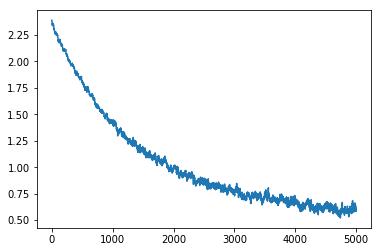

In [8]:
plt.plot(losses)
# plt.plot(losses2)